# Aufgabe 1: Hough-Transformation für Geraden
Zur Detektion parametrisch beschreibbarer Objekte in Kantenbildern kann die *Hough-Transformation* verwendet werden.
Als *Hough-Akkumulator* wird dazu im Folgenden ein diskretisierter Parameterraum bezeichnet.

1. Bei der *Geradendetektion* wird hierfür sinnvoller Weise die *Polardarstellung* gewählt. Dabei wird eine Gerade durch ihren Normalenwinkel $\varphi$ und dem Abstand $r$ zum Ursprung beschrieben, wie in untenstehender Abbildung angedeutet. Für jeden Punkt $\boldsymbol{p}=(x,y)$ im Kantenbild wird dann für alle Winkel $\varphi$ der Parameter \begin{align}r = x \cos \varphi + y \sin \varphi\end{align} einer Geraden durch diesen Kantenpunkt bestimmt. Die Einträge an den entsprechenden Stellen $(\varphi, r)$ im Hough-Akkumulator werden inkrementiert. Lokale Maxima beschreiben letztendlich diejenigen Parameterkombinationen, die Geraden im Bild darstellen, auf denen viele Kantenpunkte liegen.


2. Implementieren Sie eine Python-Funktion, welche in einem gegebenen Kantenbild die ersten $n=50$ Geraden detektiert und stellen Sie diese dar! Stellen Sie sicher, dass die einzelnen Parameter leicht verändert werden können! Visualisieren Sie ebenfalls den Hough-Akkumulator und zeigen Sie die Zusammenhänge zum Detektionsergebnis! Welchen Einfluss hat die Wahl der Größen für die Diskretisierungsschritte auf das Ergebnis?


3. Das vorgestellte Verfahren weist einige Schwächen auf, welche durch einfache Erweiterungen abgeschwächt werden können. So können die konkreten Kantenstärken beim Inkrementieren der Akkumulatorzellen berücksichtigt werden. Darüber hinaus würde eine Glättung des Akkumulators zu eindeutigen, unverrauschten Maxima führen.

Erweitern Sie Ihre Routine derart, dass sie robust gegenüber Ausreißern und Fehldetektionen wird!

![Parametrisierung einer Geraden über ihren Normalenwinkel $\varphi$ und ihren Abstand $r$ zum Ursprung.](figures/hough.svg)


## 0. Pfade, Pakete etc.

In [1]:
import glob
import urllib.request

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import imageio
import numpy as np
import math

import skimage.filters
import skimage.feature

In [2]:
# image_filter = 'Bilder/*.jpg'
image_filter = 'Bilder/Hough.jpg'

## 1. Definition der Parameter
Zuerst wird die mögliche Anzahl der Geraden $n$ definiert:

In [3]:
n=50

Zusätzlich wird die Auflösung bzw. Größe des Hough-Akkumulators in Richtung $r$ und $\varphi$ festgelegt:

In [4]:
phi_size = 180

## 2. Laden des Bildes

In [5]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Andernfalls kann der Median nicht immer korrekt berechet werden. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [6]:
image_max = np.float32(np.max(image))  # Maximum bestimmen
image_min = np.float32(np.min(image))  # Minimum bestimmen
image = (np.float32(image) - image_min) / (image_max-image_min)
# image

## 3. Kantenbild ermitteln
Die Hough-Transformation ist auf Kantenbilder anzuwenden. Um ein Kantenbild zu erhalten, verwenden Sie z.B. einen Sobel-Filter aus dem Paket `scikit-image`.

In [7]:
edge_image = skimage.filters.sobel(image)

# compute diagonal length as r_size
rows,cols= edge_image.shape
r_size=np.ceil(np.sqrt(rows**2+cols**2))

Visualisieren Sie nun das Kantenbild:

<IPython.core.display.Javascript object>


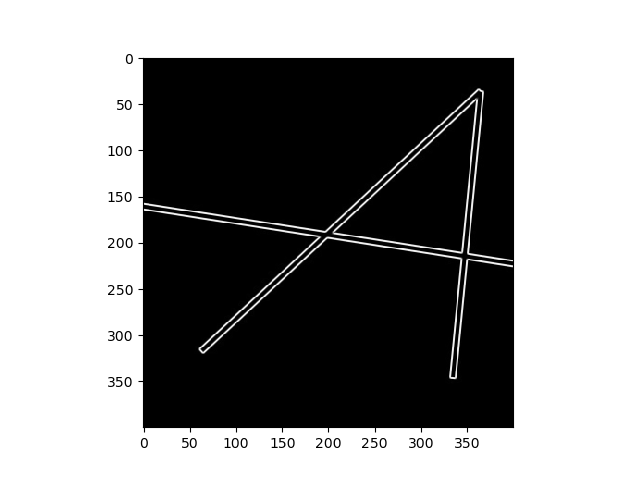

In [8]:
plt.imshow(edge_image,plt.cm.gray)

## 4. Hough-Transformation
Zunächst soll eine Funktion `ex5_hough_transform` definiert werden, die die Hough-Transformation durchführt und den Akkumulator sowie dessen Grenzwerte zurückliefert:

In [9]:
def ex5_hough_transform(edge_image):
    acc =np.zeros((int(2*r_size),phi_size),dtype=np.float32)
    r_s = np.linspace(-r_size,r_size,int(2*r_size))     # r is from -size to rize
    phi_s = np.deg2rad(np.arange(-phi_size/2,phi_size/2)) # phi is from -90 to 90
    cos_phi = np.cos(phi_s)
    sin_phi = np.sin(phi_s)
    y_inx,x_inx=np.nonzero(edge_image)
    
    rmin = min(r_s)
    rmax = max(r_s)
    phimin = min (phi_s)
    phimax = max (phi_s)

    for i in range(len(x_inx)):
        x = x_inx[i]
        y = y_inx[i]
        for j in range(phi_size):
            r = round(x * cos_phi[j] + y * sin_phi[j])+r_size
            if isinstance(r,int):
                acc[r][j] += 1
            else:
                acc[int(r)][j] +=1

    return acc,(rmin, rmax, phimin, phimax)

Der Hough-Akkumulator und dessen Grenzwerte werden jetzt ausgerechnet.

In [10]:
acc,limits = ex5_hough_transform(edge_image)
limits

(-566.0, 566.0, -1.5707963267948966, 1.5533430342749532)

Als Sanity-Check wird der Hough-Akkumulator visualisiert:

<IPython.core.display.Javascript object>


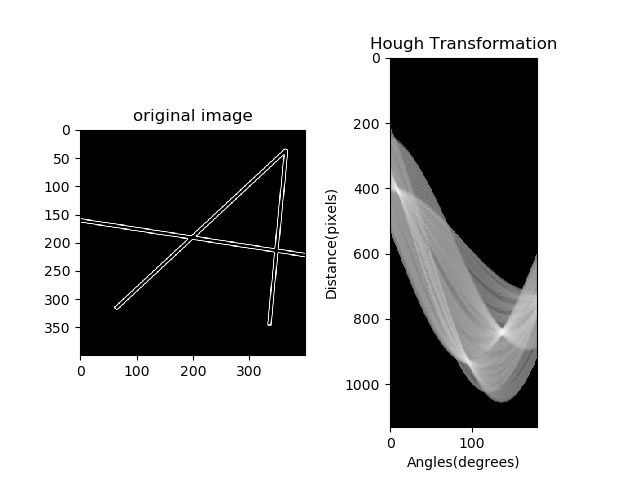

In [11]:
plt.figure('Image')

plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(edge_image, cmap='gray')

plt.subplot(1,2,2)
plt.title('Hough Transformation')
plt.xlabel("Angles(degrees)")
plt.ylabel("Distance(pixels)")
plt.imshow(np.log(1+acc), cmap='gray',aspect=1/2.5)

## 5. Geradendetektion
Definieren Sie nun eine Funktion `ex5_detect_lines`, die aus einem gegebenen Hough-Akkumulator und dessen Grenzwerten die gewünschte Anzahl Geraden als Liste von $(r,\varphi,s)$-Tupeln zurückgibt, wobei $s$ die Stärke der Gerade bezeichnet.

In [12]:
def k_largest_index_argsort(a, k): 
    idx = np.argsort(a.ravel())[:-k-1:-1] 
    return np.column_stack(np.unravel_index(idx, a.shape)) 

def ex5_detect_lines(acc,limits):
    lines = []
    
    acc_ind=k_largest_index_argsort(acc, k=n)
    for i in range(n):
        lines.append((acc_ind[i][0]-r_size,np.deg2rad(acc_ind[i][1]-90),acc[acc_ind[i][0],acc_ind[i][1]]/2))
    
    return lines

Die soeben definierte Funktion wird nun aufgerufen, um den Akkumulator zu verarbeiten:

In [13]:
lines = ex5_detect_lines(acc,limits)

Anschließend werden die Geraden visualisiert. Tipp: die `plot`-Funktion von Matplotlib kann Strecken durch Aufruf von `plt.plot([x0, x1], [y0, y1])` zeichnen.

<IPython.core.display.Javascript object>


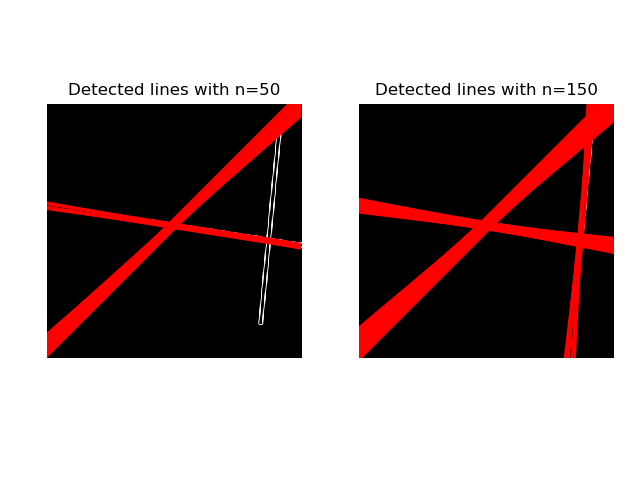

In [14]:
fig, (ax2,ax3) = plt.subplots(1, 2)
plt.tight_layout()

ax2.imshow(edge_image, plt.cm.gray)
row1, col1 = edge_image.shape
for dist, angle, _ in lines:
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax2.plot((0, col1), (y0, y1), '-r')
ax2.axis((0, col1, row1, 0))
ax2.set_title('Detected lines with n=50')
ax2.set_axis_off()

# if n=150:
n=150
lines = ex5_detect_lines(acc,limits)
ax3.imshow(edge_image, plt.cm.gray)
row1, col1 = edge_image.shape
for dist, angle, _ in lines:
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax3.plot((0, col1), (y0, y1), '-r')
ax3.axis((0, col1, row1, 0))
ax3.set_title('Detected lines with n=150')
ax3.set_axis_off()